## Drill: More clusters?

Your task is to take the $k$-means code here and see what happens when you change the value of $k$.  What solution, if any, do you find most compelling? Does complexity start to become an issue with this data set? Play around a bit and write up your findings and your process to share with your mentor.  Keep in mind that it may be possible to have a solution with more than two clusters that is still better at tracking the real binary outcome – two of those clusters may map to "heart disease" while the other maps to "no heart disease," for example.

In [1]:
import this


The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("white")

In [3]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid

## Applying the model

Let's try $k$-means on some [heart disease data](http://archive.ics.uci.edu/ml/datasets/Heart+Disease) from the UC Irvine Machine Learning Repository.  Our goal will be to create a $k$-means solution that correctly assigns patients to "heart disease diagnosis" or "no heart disease diagnosis" clusters.

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/cleveland.csv", header=None, error_bad_lines=False)

# Define the features and the outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

In [5]:
df.iloc[:, 13].unique()

array([0, 2, 1, 3, 4], dtype=int64)

To make it easier to visualize our potential clusters, we will reduce the data to 2 components using PCA.

In [6]:
# Normalize the data.
X_norm = normalize(X)
# Reduce with 95% variance explained
X_pca = PCA(n_components=.90,svd_solver='full').fit_transform(X_norm)


In [7]:
# tune with varying hyperparameters
pgd_kmn = {'n_clusters': [2, 3, 4, 5],
             'init': ['k-means++', 'random'],
             'n_init':[5, 10, 15]}
hprs_kmn =list(ParameterGrid(pgd_kmn))
clf_kmn = KMeans(n_clusters=2, random_state=42)
clf_mbk = MiniBatchKMeans(init='random',n_clusters=2, batch_size=200)
pgd_mbk = {'n_clusters': [2, 3, 4, 5],
             'init': ['k-means++', 'random'],
             'batch_size':[100, 200, 300]}
hprs_mbk =list(ParameterGrid(pgd_mbk))

In [8]:
%time prds_mbk = [clf_mbk.set_params(**hpr).fit_predict(X_pca) for hpr in hprs_mbk]


Wall time: 780 ms


In [9]:
%time prds_kmn = [clf_kmn.set_params(**hpr).fit_predict(X_pca) for hpr in hprs_kmn]

Wall time: 1.78 s


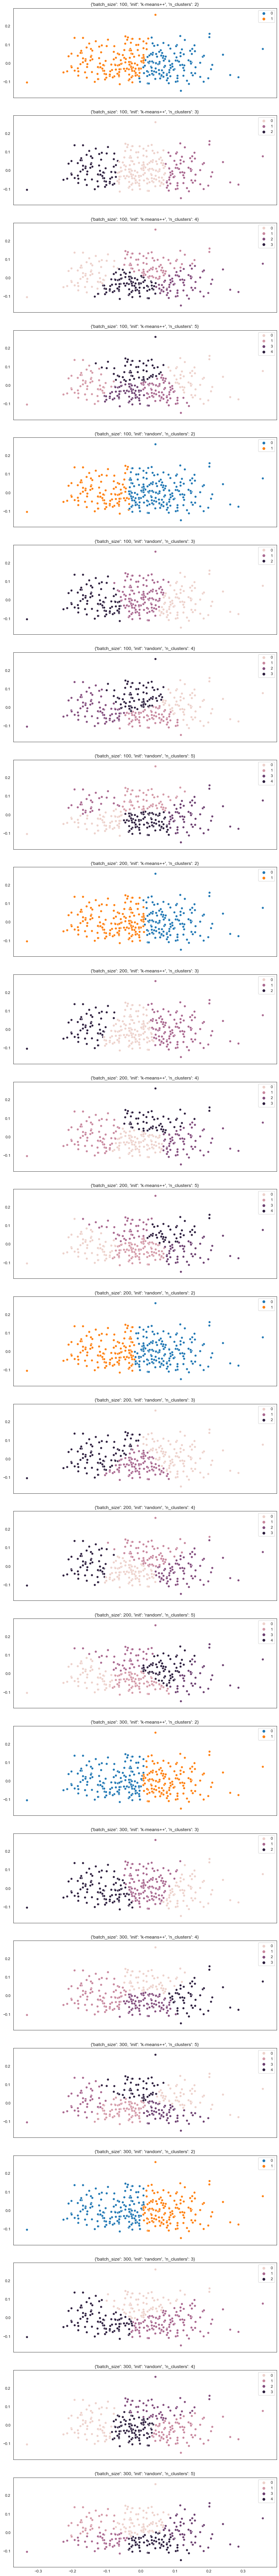

In [10]:
cols = 1; rows = len(prds_mbk) // cols 

fig, axs = plt.subplots(rows, cols, sharex='col', sharey='row', figsize=(12, rows * 5))
for (i, prd) in enumerate(prds_mbk):
        sns.scatterplot(X_pca[:, 0], X_pca[:, 1], hue=prd, ax=axs[i])
        axs[i].set_title(hprs_mbk[i])
plt.show()


In [11]:

# Check the solution against the data.
print(hprs_mbk[3])
print(pd.crosstab(prds_mbk[3], y))

{'batch_size': 100, 'init': 'k-means++', 'n_clusters': 5}
col_0   0   1
row_0        
0      17  31
1      35  19
2      21  56
3      30  38
4      36  20


In [12]:
len(y[y == 0]) / len(y)

0.45874587458745875

In [13]:
scores = []
for (i, prd) in enumerate(prds_mbk):
    ct = pd.crosstab(prd, y)
    scores.append(np.where(ct[0] >= ct[1],ct[0], ct[1] ).sum() / ct.sum().sum())


In [14]:
scores = pd.Series(scores)
print(scores.max())
print(hprs_mbk[scores.idxmax()])

0.66996699669967
{'batch_size': 300, 'init': 'random', 'n_clusters': 3}
